<a href="https://colab.research.google.com/github/nguyenngocbaocmt02/Adaptive-periodic-charging-scheme-using-state-based-reinforcement-learning-in-WRSNs/blob/main/GraphRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install simpy
!pip install simpful

# Constants and Parameters of Networks

In [ ]:
class Para:
  # Physical parameter of considered network including type of homologous nodes, base stations
  # and Mobile Chargers

  # Nodes specifications
  NODE_CAPACITY = 10800
  NODE_THRESHOLD = 540

    # MobileCharger specifications
  MC_CAPACITY = 108000 
  MC_THRESHOLD = 0
  MC_VELOCITY = 5
  MC_PM = 1
  MC_ALPHA = 4500
  MC_BETA = 30

  # others
  epsilon = 0.0000000001


In [ ]:
import numpy as np
import scipy.spatial.distance as distance
import copy
import random
import math
import simpy
from simpful import *
import matplotlib.pyplot as plt
from abc import *
import os
import random
import threading
from time import time

# Network

## Node

In [ ]:
class Node:
    # identification of a node

    def __init__(self, index, location=np.zeros(2), energy=Para.NODE_CAPACITY, energyCR=0, threshold=Para.NODE_THRESHOLD,
                 capacity=Para.NODE_CAPACITY):
        self.env = None
        self.location = location
        self.energy = energy
        self.energyCR = energyCR
        self.id = index
        self.energyRR = 0
        self.threshold = threshold
        self.capacity = capacity
        self.status = 1
        self.checkStatus()

    def operate(self, simulateTime, t=1):
        """
        The operation of a node
        :param simulateTime: the time limit of the operation
        :returns yield t(s) to time management system every t(s)
        """
        sumTime = simulateTime
        while sumTime != 0:
            if sumTime < t:
                t = sumTime
            # if self.id == 0:
            # print(str(self.env.now)+" "+str(self.energy)+" "+str(self.energyRR))
            if self.status == 0:
                sumTime -= t
                yield self.env.timeout(t)
                continue
            self.energy = min(max(self.energy - t * self.energyCR + t * self.energyRR, self.threshold), self.capacity)
            self.checkStatus()
            sumTime -= t
            yield self.env.timeout(t)

        return

    def charged(self, mc):
        if self.status == 1:
            self.energyRR += mc.alpha / (distance.euclidean(self.location, mc.location) + mc.beta) ** 2

    def chargingDisconnect(self, mc):
        if self.status == 1:
            self.energyRR -= mc.alpha / (distance.euclidean(self.location, mc.location) + mc.beta) ** 2

    def checkStatus(self):
        if self.energy <= self.threshold:
            self.status = 0
            self.energyRR = 0
            self.energyCR = 0


##ChargingLocation

In [ ]:
class ChargingLocation:
    def __init__(self, location, listNodes):
        self.location = location
        self.listNodes = listNodes


##BaseStation

In [ ]:
class BaseStation:
    def __init__(self, location):
        """
        The initialization for basestation
        :param location: the coordinate of a basestation
        """
        self.env = None
        self.location = location

    def chargeMC(self, mc, t=0):
        """
        MC is replenished at the base station. It takes 0(s) to replace the battery
        :param mc: the mc needs charging
        :param t: the time to replenish
        :return: yield t(s) to time management system (in this case, t = 0)
        """
        if distance.euclidean(mc.location, self.location) == 0:
            mc.energy = mc.capacity
        yield self.env.timeout(t)

##Network

In [ ]:
class Network:
    def __init__(self, env, listNodes, baseStation):
        self.env = env
        self.listNodes = listNodes
        self.baseStation = baseStation
        for node in self.listNodes:
            node.env = self.env
        baseStation.env = self.env

    def runNetwork(self, simulateTime):
        """
        The operation of a network
        :param simulateTime: the time limit of the operation
        """
        for node in self.listNodes:
            self.env.process(node.operate(simulateTime=simulateTime))
        yield self.env.timeout(simulateTime)
        return

    def countDeadNodes(self):
        """
        :return return the number of dead nodes
        """
        count = 0
        for node in self.listNodes:
            if node.status == 0:
                count += 1
        return count


#MobieCharger

In [ ]:
class MobileCharger:

    def __init__(self, index, env, location, capacity=Para.MC_CAPACITY, threshold=Para.MC_THRESHOLD,
                 alpha=Para.MC_ALPHA, beta=Para.MC_BETA,
                 velocity=Para.MC_VELOCITY, pm=Para.MC_PM):
        """
        The initialization for a MC. The default value of these params are in the Parameter.py
        :param env: the time management system of this MC
        :param location: the initial coordinate of this MC, usually at the base station
        :param capacity: the capacity of this MC
        :param threshold: the threshold of this MC
        :param alpha: the charging rate regarding the Friss's function
        :param beta: another charging rate regarding the Friss's function
        :param velocity: the velocity of this MC
        :param pm: the moving rate of this MC
        """
        self.env = env
        self.location = location
        self.energy = capacity
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.threshold = threshold
        self.velocity = velocity
        self.pm = pm

        self.id = index

        self.chargingRate = 0

        self.schedule = []

        self.status = 1
        self.checkStatus()
        self.log = []

    def move(self, destination, simulateTime, t=1):
        """
        The movement within simulateTime to a destination :param destination: the final destination of this movement
        :param simulateTime: the time limit of movement. The MC may not reach the destination if the simulateTime is
        run out
        :param t: the status of MC is updated every t(s)
        :return yield t(s) to time management system every t(s) and terminate when MC reaches the destination
        """
        sumTime = simulateTime
        while distance.euclidean(self.location, destination) > Para.epsilon:
            if sumTime < t:
                t = sumTime
            if self.status == 0:
                print("MC run out of energy while moving from !" + str(self.location))
                yield self.env.timeout(sumTime)
                sumTime = 0
                continue
            else:
                energyConsume = distance.euclidean(self.location, destination) / self.velocity * self.pm
                movingVector = [destination[i] - self.location[i] for i in range(0, len(self.location))]
                movingTime = distance.euclidean(self.location, destination) / self.velocity
                if movingTime > t:
                    energyConsume = energyConsume / movingTime * t
                    movingVector = [i / movingTime * t for i in movingVector]
                    movingTime = t
                else:
                    t = movingTime
                if self.energy - energyConsume <= self.threshold:
                    movingVector = [i / ((self.energy - self.threshold) / energyConsume) for i in movingVector]
                    energyConsume = self.energy - self.threshold
                self.location = [self.location[i] + movingVector[i] for i in range(0, len(self.location))]
                self.energy = self.energy - energyConsume
                self.checkStatus()
                sumTime -= t
                yield self.env.timeout(t)

    def chargeNodes(self, chargingTime, simulateTime, nodes, t=1):
        """
        The charging process to nodes in 'nodes' within simulateTime
        :param nodes: the set of charging nodes
        :param t: the status of MC is updated every t(s)
        :param chargingTime: the charging time
        :param simulateTime: the time limit
        """
        sumTime = min(chargingTime, simulateTime)
        while sumTime > Para.epsilon:
            if sumTime < t:
                t = sumTime
            if self.status == 0:
                print("MC run out of energy while charging at !" + str(self.location))
                yield self.env.timeout(sumTime)
                sumTime = 0
                continue
            self.setChargingRate(nodes)
            if self.status == 0:
                sumTime -= t
                yield self.env.timeout(t)
                continue
            self.energy = max(self.threshold, self.energy - self.chargingRate * t)
            self.checkStatus()
            sumTime -= t
            yield self.env.timeout(t)
            self.chargingDisconnect(nodes)

    def setChargingRate(self, nodes):
        """
        Set up the charging rate when charging nodes
        :param nodes: the set of charging nodes
        """
        tmp = 0
        for node in nodes:
            if node.status == 0:
                continue
            d = distance.euclidean(self.location, node.location)
            tmp += self.alpha / (d + self.beta) ** 2
            node.charged(mc=self)
        self.chargingRate = tmp

    def chargingDisconnect(self, nodes):
        """
        Disconnect the charging process
        :param nodes: the set of charging nodes
        """
        for node in nodes:
            if node.status == 0:
                continue
            node.chargingDisconnect(mc=self)
        self.chargingRate = 0

    def operate(self, net, simulateTime, optimizer=None):
        """
        The operation of MC
        :param net: the network
        :param simulateTime: the simulate time
        :param optimizer: if the  schedule list of MC is empty, the on-demand algorithm will provide the next action
        instantly , the offline algorithm will wait until the checkpoint
        :returns return time of charging and moving to time management system
        """
        while True:
            if len(self.schedule) == 0:
                if optimizer is None:
                    break
                elif optimizer.optimizeType == "On-demand":
                    self.schedule.append(optimizer.schedule(net=net, mc=self))
                elif optimizer.optimizeType == "Offline":
                    yield self.env.timeout(optimizer.checkPoint - self.env.now)
            else:
                action = self.schedule[0]
                self.log.append(action)
                destination = action[0]
                chargingTime = action[1]
                nodes = action[2]
                yield self.env.process(
                    self.move(destination=destination, simulateTime=simulateTime))
                # print('Time: ' + str(self.env.now) + ", MC " + str(self.id) + ' is at ' + str(self.location))
                if self.location != net.baseStation.location and len(nodes) != 0:
                    prior = self.energy
                    yield self.env.process(
                        self.chargeNodes(chargingTime=chargingTime, simulateTime=simulateTime,
                                         nodes=nodes))
                    self.log[-1].append(prior - self.energy)
                else:
                    yield self.env.process(net.baseStation.chargeMC(self, chargingTime))
                    self.log[-1].append(0)
                del self.schedule[0]

        return

    def checkStatus(self):
        """
        check the status of MC
        """
        if self.energy <= self.threshold:
            self.status = 0


#Optimizer

##Optimizer

In [ ]:
class Optimizer(ABC):
    def __init__(self, optimizeType):
        """
        An optimizer
        :param optimizeType: the type of this optimizer(OnDemand or Offline)
        """
        ABC.__init__(self)
        self.optimizeType = optimizeType


##OfflineOptimizer


In [ ]:
class OfflineOptimizer(Optimizer):
    def __init__(self, env, checkPoint=0):
        Optimizer.__init__(self, optimizeType='Offline')
        self.checkPoint = checkPoint
        self.env = env

    @abstractmethod
    def schedule(self, net, mcs):
        pass

    def controller(self, mcs, net):
        while True:
            yield self.env.timeout(self.checkPoint - self.env.now)
            self.schedule(mcs, net)


#GraphRL

##GraphRlOptimizer

In [ ]:
class GraphRlOptimizer(OfflineOptimizer, ABC):
    def __init__(self, env, T, testedT, trimming = 0.8, delta = 100, nepisode = 30000, reward_factor = 100):
        OfflineOptimizer.__init__(self, env=env)
        self.checkPoint = 0
        self.T = T
        self.nepisode = nepisode
        self.testedT = testedT
        self.fuzzy = FuzzyCS()
        self.delta = delta
        self.trimming = trimming
        self.log = []
        self.reward_log = []
        self.runtime = 0
        self.reward_factor = reward_factor

    def schedule(self, mcs, net):
        mc = mcs[0]
        print('Time: ' + str(self.env.now) + ' The number of dead node:' + str(net.countDeadNodes()))
        self.log.append(net.countDeadNodes())
        T = min(self.T, self.testedT - self.env.now)
        t0 = time()
        Esafe = self.fuzzy.operate(net, self.T, mc)
        if T == self.testedT - self.env.now:
            for i in range(len(Esafe)):
                if net.listNodes[i].status == 0:
                    Esafe[i] = 0
                else:
                    Esafe[i] = 600
        t1 = time()
        print(Esafe)
        self.checkPoint += self.T
        graph = StatusGraph(net=net, mc=mc, delta=self.delta, T=T, Esafe=Esafe, trimming=self.trimming, reward_factor=self.reward_factor)
        t2 = time()
        graph.initialize()
        t3 = time()
        self.runtime += t1 - t0 + t3 - t2
        self.reward_log.append(graph.log)
        # schedule MC
        for ver in graph.path:
            mc.schedule.append([ver.node.location, ver.chargingTime, [ver.node]])
            print(str(ver.node.energyCR) + "     " + str(ver.node.energy - self.T * ver.node.energyCR + graph.U * ver.chargingTime))
        mc.schedule.append([net.baseStation.location, 0, []])
        del graph


##FuzzyCS


In [ ]:
class FuzzyCS:
    def __init__(self):
        self.FS = FuzzySystem()
        self.initialize()

    def initialize(self):
        FS = self.FS
        U_1 = FuzzySet(function=Trapezoidal_MF(a=0, b=0, c=0.15, d=0.45), term='low')
        U_2 = FuzzySet(function=Trapezoidal_MF(a=0.15, b=0.45, c=0.75, d=0.85), term='moderate')
        U_3 = FuzzySet(function=Trapezoidal_MF(a=0.75, b=0.85, c=1, d=1), term='high')
        LV1 = LinguisticVariable([U_1, U_2, U_3], concept='U', universe_of_discourse=[0, 1])
        FS.add_linguistic_variable('U', LV1)
        LV1.plot()

        ESR_1 = FuzzySet(function=Trapezoidal_MF(a=0, b=0, c=0.2, d=0.25), term='low')
        ESR_2 = FuzzySet(function=Trapezoidal_MF(a=0.2, b=0.25, c=0.45, d=0.55), term='moderate')
        ESR_3 = FuzzySet(function=Trapezoidal_MF(a=0.45, b=0.55, c=1, d=1), term='high')
        LV2 = LinguisticVariable([ESR_1, ESR_2, ESR_3], concept='ESR', universe_of_discourse=[0, 1])
        FS.add_linguistic_variable('ESR', LV2)
        LV2.plot()

        E_1 = FuzzySet(function=Trapezoidal_MF(a=0, b=0, c=0.15, d=0.5), term='low')
        E_2 = FuzzySet(function=Trapezoidal_MF(a=0.15, b=0.5, c=0.75, d=0.85), term='moderate')
        E_3 = FuzzySet(function=Trapezoidal_MF(a=0.75, b=0.85, c=1, d=1), term='high')
        LV3 = LinguisticVariable([E_1, E_2, E_3], concept='E', universe_of_discourse=[0, 1])
        FS.add_linguistic_variable('E', LV3)
        LV3.plot()

        SAFE_0 = FuzzySet(function=Trapezoidal_MF(a=0, b=0, c=0.05, d=0.15), term='exlow')
        SAFE_1 = FuzzySet(function=Trapezoidal_MF(a=0.05, b=0.15, c=0.2, d=0.3), term='verylow')
        SAFE_2 = FuzzySet(function=Trapezoidal_MF(a=0.2, b=0.3, c=0.35, d=0.45), term='low')
        SAFE_3 = FuzzySet(function=Trapezoidal_MF(a=0.35, b=0.45, c=0.5, d=0.6), term='moderate')
        SAFE_4 = FuzzySet(function=Trapezoidal_MF(a=0.5, b=0.6, c=0.65, d=0.75), term='high')
        SAFE_5 = FuzzySet(function=Trapezoidal_MF(a=0.65, b=0.75, c=0.8, d=0.9), term='veryhigh')
        SAFE_6 = FuzzySet(function=Trapezoidal_MF(a=0.8, b=0.9, c=1, d=1), term='exhigh')

        LV4 = LinguisticVariable([SAFE_0, SAFE_1, SAFE_2, SAFE_3, SAFE_4, SAFE_5, SAFE_6], concept='SAFE',
                                 universe_of_discourse=[0, 1])
        FS.add_linguistic_variable('SAFE', LV4)
        LV4.legend(loc='upper left')
        LV4.plot()
        

        # Define fuzzy rules
        R1 = 'IF (U IS low) AND (ESR IS low) AND (E IS low) THEN (SAFE IS exlow)'
        R2 = 'IF (U IS low) AND (ESR IS low) AND (E IS moderate) THEN (SAFE IS exlow)'
        R3 = 'IF (U IS low) AND (ESR IS low) AND (E IS high) THEN (SAFE IS exlow)'
        R4 = 'IF (U IS low) AND (ESR IS moderate) AND (E IS low) THEN (SAFE IS moderate)'
        R5 = 'IF (U IS low) AND (ESR IS moderate) AND (E IS moderate) THEN (SAFE IS moderate)'
        R6 = 'IF (U IS low) AND (ESR IS moderate) AND (E IS high) THEN (SAFE IS moderate)'
        R7 = 'IF (U IS low) AND (ESR IS high) AND (E IS low) THEN (SAFE IS veryhigh)'
        R8 = 'IF (U IS low) AND (ESR IS high) AND (E IS moderate) THEN (SAFE IS veryhigh)'
        R9 = 'IF (U IS low) AND (ESR IS high) AND (E IS high) THEN (SAFE IS veryhigh)'

        R10 = 'IF (U IS moderate) AND (ESR IS low) AND (E IS low) THEN (SAFE IS exlow)'
        R11 = 'IF (U IS moderate) AND (ESR IS low) AND (E IS moderate) THEN (SAFE IS verylow)'
        R12 = 'IF (U IS moderate) AND (ESR IS low) AND (E IS high) THEN (SAFE IS verylow)'
        R13 = 'IF (U IS moderate) AND (ESR IS moderate) AND (E IS low) THEN (SAFE IS moderate)'
        R14 = 'IF (U IS moderate) AND (ESR IS moderate) AND (E IS moderate) THEN (SAFE IS high)'
        R15 = 'IF (U IS moderate) AND (ESR IS moderate) AND (E IS high) THEN (SAFE IS high)'
        R16 = 'IF (U IS moderate) AND (ESR IS high) AND (E IS low) THEN (SAFE IS veryhigh)'
        R17 = 'IF (U IS moderate) AND (ESR IS high) AND (E IS moderate) THEN (SAFE IS exhigh)'
        R18 = 'IF (U IS moderate) AND (ESR IS high) AND (E IS high) THEN (SAFE IS exhigh)'

        R19 = 'IF (U IS high) AND (ESR IS low) AND (E IS low) THEN (SAFE IS exlow)'
        R20 = 'IF (U IS high) AND (ESR IS low) AND (E IS moderate) THEN (SAFE IS verylow)'
        R21 = 'IF (U IS high) AND (ESR IS low) AND (E IS high) THEN (SAFE IS low)'
        R22 = 'IF (U IS high) AND (ESR IS moderate) AND (E IS low) THEN (SAFE IS moderate)'
        R23 = 'IF (U IS high) AND (ESR IS moderate) AND (E IS moderate) THEN (SAFE IS high)'
        R24 = 'IF (U IS high) AND (ESR IS moderate) AND (E IS high) THEN (SAFE IS veryhigh)'
        R25 = 'IF (U IS high) AND (ESR IS high) AND (E IS low) THEN (SAFE IS veryhigh)'
        R26 = 'IF (U IS high) AND (ESR IS high) AND (E IS moderate) THEN (SAFE IS exhigh)'
        R27 = 'IF (U IS high) AND (ESR IS high) AND (E IS high) THEN (SAFE IS exhigh)'

        FS.add_rules(
            [R1, R2, R3, R4, R5, R6, R7, R8, R9, R10, R11, R12, R13, R14, R15, R16, R17, R18, R19, R20, R21, R22, R23,
             R24, R25, R26, R27])

    def operate(self, net, T, mc):
        safeEnergy = []
        maxESR = 0.0001
        sumESR = 0
        aliveNode = 0
        sumE = 0
        for node in net.listNodes:
            if node.status == 0:
                continue
            aliveNode += 1
            maxESR = max(maxESR, node.energyCR)
            sumESR += node.energyCR
            sumE += node.energy

        sumECharge = mc.capacity - (net.baseStation.location[0] * 2) * math.sqrt(2) / 5 * aliveNode
        print(str((mc.alpha / (mc.beta ** 2)) / (sumESR)) + '  '+ str(mc.capacity / (sumESR * T)))
        for node in net.listNodes:
            if node.status == 0:
                safeEnergy.append(0)
            else:
                self.FS.set_variable('U', (mc.alpha / (mc.beta ** 2)) / (sumESR))
                self.FS.set_variable('ESR', node.energyCR / ((node.capacity - node.threshold) / T))
                self.FS.set_variable('E', mc.capacity / (sumESR * T))
                # Perform Madman inference and print output
                safeEnergy.append(
                    ((self.FS.Mamdani_inference(['SAFE'])['SAFE']) * (node.capacity - node.threshold) + node.threshold ) )
            # print(str(RS) + " " + str(node.energyCR / maxESR)+" "+str(safeEnergy[-1]))
        return safeEnergy


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.6.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



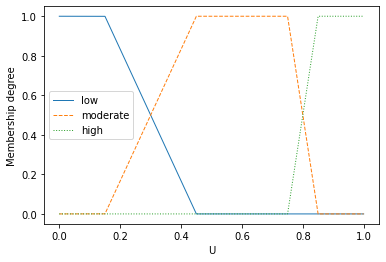

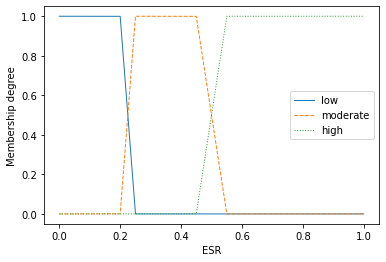

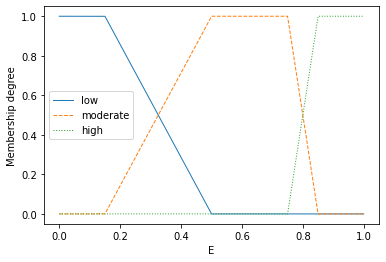

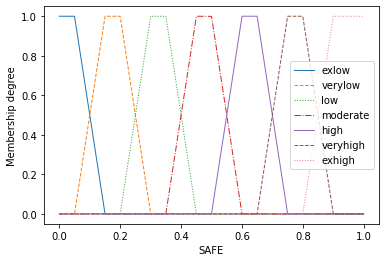

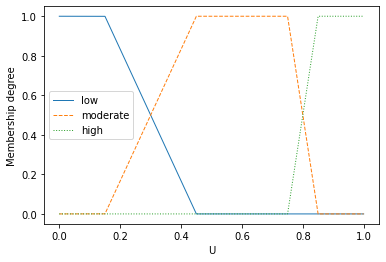

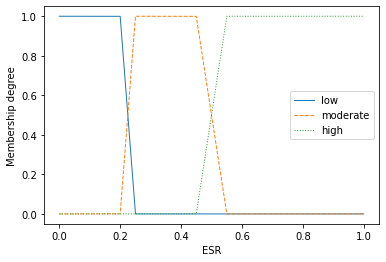

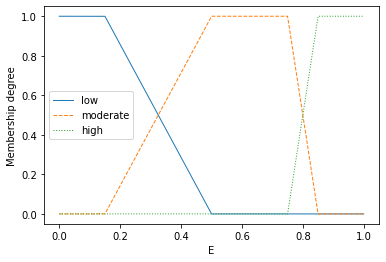

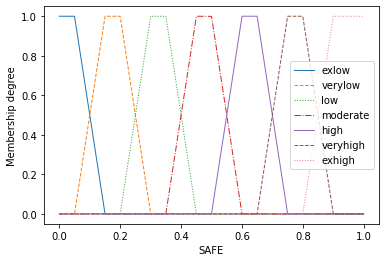

In [ ]:
x = FuzzyCS()
x.initialize()

##Vertex

In [ ]:
class Vertex:
    def __init__(self, lowerArrivalTime, upperArrivalTime, chargingTime, node=None, endVertex=False, reward=0):
        self.node = node
        self.lowerArrivalTime = lowerArrivalTime
        self.upperArrivalTime = upperArrivalTime
        self.adjacent = []
        self.chargingTime = chargingTime
        self.endVertex = endVertex
        self.reward = reward
        self.value = 0
        self.N = 0


##StatusGraph

In [ ]:
class StatusGraph:
    def __init__(self, net, mc, Esafe, delta=100, T=18000, trimming = 0.8, reward_factor = 100):
        self.delta = delta
        self.net = net
        self.mc = mc
        self.mapNodeVertexes = [{} for i in range(len(self.net.listNodes))]
        self.U = self.mc.alpha / (self.mc.beta ** 2)
        self.T = T
        self.Esafe = Esafe
        self.path = []
        self.Gt = []
        self.start = Vertex(0, 0, 0)
        self.visited = [False for i in range(len(self.net.listNodes))]
        self.epi = 1
        self.eMC = 0
        self.trimming = trimming
        self.log = []
        self.active_node = []
        self.reward_factor = reward_factor

    def upperNormalize(self, value):
        tmp = int(value / self.delta)
        if tmp * self.delta < value:
            tmp += 1
        return tmp * self.delta

    def lowerNormalize(self, value):
        return int(value / self.delta) * self.delta

    def initialize(self):
        tmp = []
        for node in self.net.listNodes:
            if node.status == 0:
                continue
            if (self.Esafe[node.id] - (node.energy - self.T * node.energyCR)) / self.U > 0:
                self.active_node.append(node)
                continue
            tmp.append([node.id, (node.energy - node.threshold) / node.energyCR])
        choosenList = sorted(tmp, key = lambda item: item[1])
        tmp.clear()
        for i in range (0, int(len(choosenList) * (1-self.trimming))):
            self.active_node.append(self.net.listNodes[choosenList[i][0]])
            
        for node in self.active_node:
            # lower bound of arrival time
            lowerBound = self.upperNormalize(
             self.dis(node.location, self.net.baseStation.location) / self.mc.velocity)

            # upper bound of arrival time
            upperBound = self.lowerNormalize(min(self.T - self.dis(node.location,
                                                                             self.net.baseStation.location) /
                                                 self.mc.velocity,
                                                 (node.energy - node.threshold) / node.energyCR))
            upperBound -= self.delta
            tcSafe = (self.Esafe[node.id] - (node.energy - self.T * node.energyCR)) / self.U
            # trimming the tree
            # the node with lots of energy will no need more energy so we will charge full for these node
            if tcSafe <= 0:
                tcSafe = (self.T * node.energyCR) / self.U
            l = lowerBound
            # discrete the time
            while l <= upperBound:
                reward = 0
                endVertex = False
                tc = min(tcSafe,
                         (node.capacity - (node.energy - (l + self.delta) * node.energyCR)) / (self.U - node.energyCR))
                # to fix the charging time if it exceeds T
                if l + self.delta + tc + self.dis(node.location, self.net.baseStation.location) / \
                        self.mc.velocity >= self.T - 1:
                    tc = self.T - self.dis(node.location, self.net.baseStation.location) / \
                         self.mc.velocity - l - self.delta
                    endVertex = True
                # reward obtained by charging
                # reward obtained by charging
                if node.energy - self.T * node.energyCR + tc * self.U > node.threshold:
                  reward = math.pow(self.reward_factor, tc * self.U / (self.Esafe[node.id] - node.energy + self.T * node.energyCR))
                if node.energy - self.T * node.energyCR <= node.threshold and node.energy - self.T * node.energyCR + tc * self.U > node.threshold:
                    reward += self.reward_factor

                self.mapNodeVertexes[node.id][l] = Vertex(node=node, lowerArrivalTime=l,
                                                          upperArrivalTime=l + self.delta,
                                                          chargingTime=tc, endVertex=endVertex, reward=reward)
                l += self.delta
        for node in self.active_node:
            dic = self.mapNodeVertexes[node.id]
            for vertex in dic.values():
                self.setNeighbors(vertex)
        for node in self.active_node:
            i = node.id
            dic= self.mapNodeVertexes[node.id]
            if self.upperNormalize(
                 self.dis(self.net.listNodes[i].location
                        , self.net.baseStation.location) / self.mc.velocity) in dic.keys():
                self.start.adjacent.append(dic[self.upperNormalize(
                 self.dis(self.net.listNodes[i].location
                                       , self.net.baseStation.location) / self.mc.velocity)])
        self.epi = 1

        for i in range(1, 30000):
            if i == 30000:
                self.epi = 0
            self.visited = [False for i in range(len(self.net.listNodes))]
            self.path.clear()
            self.Gt.clear()
            self.eMC = 0
            self.dfs(self.start)
            self.log.append(self.Gt[-1])
            # print(str(i)+" "+str(self.Gt[-1]))
            for j, vertex in enumerate(self.path):
                vertex.N += 1
                vertex.value = vertex.value + 1.0 / vertex.N * (self.Gt[-1] - self.Gt[j] - vertex.value)
            self.epi = max(1 / math.sqrt(i), 0.01)

    def setNeighbors(self, vertex):
        sumTime = 0
        if vertex.endVertex:
            return
        for node in self.active_node:
            if vertex.node.id == node.id:
                continue
            sumTime = vertex.chargingTime + self.dis(node.location,
                                                               vertex.node.location) / self.mc.velocity
            sumTime = self.upperNormalize(sumTime)
            if sumTime + vertex.lowerArrivalTime in self.mapNodeVertexes[node.id].keys():
                vertex.adjacent.append(self.mapNodeVertexes[node.id][vertex.lowerArrivalTime + sumTime])

    def dis(self, a, b):
        return math.sqrt((a[0] - b[0]) * (a[0] - b[0]) + (a[1] - b[1]) * (a[1] - b[1]))


    def dfs(self, vertex):
        if len(vertex.adjacent) == 0:
            return
        if len(self.path) == 0:
            curMC = self.net.baseStation.location
        else:
            curMC = self.path[-1].node.location
        next = None
        tmp = []
        for ver in vertex.adjacent:
            if not self.visited[ver.node.id]:
                tmp.append(ver)
                if next is None:
                    next = ver
                    continue
                if ver.value + ver.reward > next.value + next.reward:
                    next = ver
        if next is None:
            return
        if random.random() < self.epi:
            next = tmp[random.randint(0, len(tmp) - 1)]
        if self.eMC + self.dis(curMC, next.node.location) / self.mc.velocity * self.mc.pm + next.chargingTime * self.U + self.dis(self.net.baseStation.location, next.node.location) / self.mc.velocity * self.mc.pm > self.mc.capacity:
            return
        self.path.append(next)
        if len(self.Gt) == 0:
            self.Gt.append(next.reward)
        else:
            self.Gt.append(next.reward + self.Gt[-1])
        self.visited[next.node.id] = True
        self.eMC += self.dis(curMC, next.node.location) / self.mc.velocity * self.mc.pm + next.chargingTime * self.U
        self.dfs(next)

#iostream

##Util

In [ ]:
class Util:
    def __init__(self, filePath):
        self.filePath = filePath
        self.listNodes = []
        f = open(self.filePath, 'r')
        lines = f.readlines()
        it = 0
        for i, line in enumerate(lines):
            if i == 0:
                tmp = tuple(map(float, line.split(" ")[:2]))
                self.BaseStation = BaseStation([tmp[0], tmp[1]])
                continue
            tmp = tuple(map(float, line.split(" ")[:4]))
            self.listNodes.append(Node(index = it,energy=tmp[3], energyCR=tmp[2], location=[tmp[0], tmp[1]]))
            it += 1

    def setUpNetwork(self, enviroment):
        network = Network(env=enviroment, listNodes=self.listNodes, listMCs=self.listMCs,
                          listChargingLocations=self.listChargingLocations,
                          baseStation=self.BaseStation)
        return network


#Main

##runner_GraphRL


In [ ]:
random.seed(1)
util = Util("/content/drive/MyDrive/data/ga200.txt")
env = simpy.Environment()
net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
mc = MobileCharger(index = 0, env=env, location=[250, 250])
testedT = 72000
algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT, trimming=0.8, reward_factor=100, delta=100)

env.process(mc.operate(net, testedT, algorithm))
env.process(algorithm.controller(mcs=[mc], net=net))
env.process(net.runNetwork(testedT))

env.run(until=testedT)
print(algorithm.log)
print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.4 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.18351587045247672  0.22021904454297206
[1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 1391.984609290922, 8398.697128580157, 1391.984609290922, 5632.410569137262, 5632.410569137262, 5632.410569137262, 1391.984609290922, 1391.9

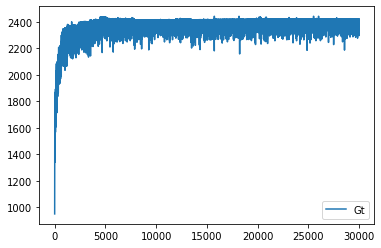

In [ ]:
tmp = algorithm.reward_log
temp = []
for num in range(len(tmp[0])):
    avg = 0.0
    for case in tmp:
      avg += case[num]
    if len(tmp) != 0:
      temp.append(avg/(len(tmp)))
plt.plot(temp, label ='Gt')
plt.legend()
plt.show() 

##experiment1


In [ ]:

def runFile(fileName, index):
    util = Util(fileName)
    env = simpy.Environment()
    net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
    mc = MobileCharger(index=0, env=env, location=[250, 250])
    testedT = 72000
    algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT)

    env.process(mc.operate(net, testedT, algorithm))
    env.process(algorithm.controller(mcs=[mc], net=net))
    env.process(net.runNetwork(testedT))
    env.run(until=testedT)
    results[index].append(net.countDeadNodes())
    log = mc.log
    t1 = 0
    t2 = 0
    now = net.baseStation.location
    for action in log:
        t1 = t1 + distance.euclidean(now, action[0]) / mc.velocity * mc.pm
        t2 = t2 + action[3]
    moving[index].append(t1)
    charging[index].append(t2)
    print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))


def toLine(tF, arr):
    res = tF + '\t'
    avg = 0
    for num in arr:
        res = res + str(num) + '\t'
        avg += num
    if len(arr) != 0:
        avg /= len(arr)
    res = res + str(avg) + '\n'
    return res

def writeTxt():
    resultFile = open(resultFolder + '/' + 'result.txt', 'w')
    movingFile = open(resultFolder + '/' + 'movingEnergy.txt', 'w')
    chargingFile = open(resultFolder + '/' + 'chargingEnergy.txt', 'w')
    for i, line in enumerate(results):
        resultFile.write(toLine(listFile[i], results[i]))
        movingFile.write(toLine(listFile[i], moving[i]))
        chargingFile.write(toLine(listFile[i], charging[i]))
    resultFile.close()
    movingFile.close()
    chargingFile.close()


dataFolder = "/content/drive/MyDrive/data"
resultFolder = "/content/drive/MyDrive/result/experiment1"
listFile = os.listdir(dataFolder)
results = []
moving = []
charging = []
seed_num = 1
for i in range(len(listFile)):
    results.append([])
    charging.append([])
    moving.append([])
for seed in range(seed_num):
    random.seed(seed)
    threads = []
    for i, fileName in enumerate(listFile):
        threads.append(threading.Thread(target=runFile, args=(dataFolder + '/' + fileName, i,)))
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
writeTxt()
print(results)


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1  Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)


 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.1474004457389479  0.17688053488673747
Time: 0 The number of dead node:0
0.13866125333133655  0.166393503997603860.

##experiment2


In [ ]:
def runFile(fileName, index, P):
    util = Util(fileName)
    for node in util.listNodes:
      node.energyCR *= P
    env = simpy.Environment()
    net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
    mc = MobileCharger(index=0, env=env, location=[250, 250])
    testedT = 72000
    algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT)

    env.process(mc.operate(net, testedT, algorithm))
    env.process(algorithm.controller(mcs=[mc], net=net))
    env.process(net.runNetwork(testedT))
    env.run(until=testedT)
    results[index].append(net.countDeadNodes())
    log = mc.log
    t1 = 0
    t2 = 0
    now = net.baseStation.location
    for action in log:
        t1 = t1 + distance.euclidean(now, action[0]) / mc.velocity * mc.pm
        t2 = t2 + action[3]
    moving[index].append(t1)
    charging[index].append(t2)
    print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))


def toLine(tF, arr):
    res = str(tF) + '\t'
    avg = 0
    for num in arr:
        res = res + str(num) + '\t'
        avg += num
    if len(arr) != 0:
        avg /= len(arr)
    res = res + str(avg) + '\n'
    return res

def writeTxt():
    resultFile = open(resultFolder + '/' + 'result.txt', 'w')
    movingFile = open(resultFolder + '/' + 'movingEnergy.txt', 'w')
    chargingFile = open(resultFolder + '/' + 'chargingEnergy.txt', 'w')
    for i, line in enumerate(results):
        resultFile.write(toLine(listP[i], results[i]))
        movingFile.write(toLine(listP[i], moving[i]))
        chargingFile.write(toLine(listP[i], charging[i]))
    resultFile.close()
    movingFile.close()
    chargingFile.close()


dataFile = "/content/drive/MyDrive/data/ga200.txt"
resultFolder = "/content/drive/MyDrive/result/experiment2"
listP = [0.75, 1, 1.25, 1.5, 1.75]
results = []
moving = []
charging = []
seed_num = 1
for i in range(len(listP)):
    results.append([])
    charging.append([])
    moving.append([])
for seed in range(seed_num):
    random.seed(seed)
    threads = []
    for i, P in enumerate(listP):
        threads.append(threading.Thread(target=runFile, args=(dataFile, i, P,)))
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
writeTxt()
print(results)


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\   ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 

 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl) (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.24468782726996896  0.29362539272396276
  ____  __  _  _  ____  ____  _  _  __   
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
  ____  __  _  _  ____  ____  _  _  __   0.1468126963619814  0.1761752356343777

 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \_

##experiment3

In [ ]:
def runFile(fileName, index, U):
    util = Util(fileName)
    env = simpy.Environment()
    net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
    mc = MobileCharger(index=0, alpha=U/5.0*4500.0, env=env, location=[250, 250])
    testedT = 72000
    algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT)

    env.process(mc.operate(net, testedT, algorithm))
    env.process(algorithm.controller(mcs=[mc], net=net))
    env.process(net.runNetwork(testedT))
    env.run(until=testedT)
    results[index].append(net.countDeadNodes())
    log = mc.log
    t1 = 0
    t2 = 0
    now = net.baseStation.location
    for action in log:
        t1 = t1 + distance.euclidean(now, action[0]) / mc.velocity * mc.pm
        t2 = t2 + action[3]
    moving[index].append(t1)
    charging[index].append(t2)
    print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))


def toLine(tF, arr):
    res = str(tF) + '\t'
    avg = 0
    for num in arr:
        res = res + str(num) + '\t'
        avg += num
    if len(arr) != 0:
        avg /= len(arr)
    res = res + str(avg) + '\n'
    return res

def writeTxt():
    resultFile = open(resultFolder + '/' + 'result.txt', 'w')
    movingFile = open(resultFolder + '/' + 'movingEnergy.txt', 'w')
    chargingFile = open(resultFolder + '/' + 'chargingEnergy.txt', 'w')
    for i, line in enumerate(results):
        resultFile.write(toLine(listU[i], results[i]))
        movingFile.write(toLine(listU[i], moving[i]))
        chargingFile.write(toLine(listU[i], charging[i]))
    resultFile.close()
    movingFile.close()
    chargingFile.close()


dataFile = "/content/drive/MyDrive/data/ga200.txt"
resultFolder = "/content/drive/MyDrive/result/experiment3"
listU = [2.5, 5, 7.5, 10, 12.5]
results = []
moving = []
charging = []
seed_num = 1
for i in range(len(listU)):
    results.append([])
    charging.append([])
    moving.append([])
for seed in range(seed_num):
    random.seed(seed)
    threads = []
    for i, U in enumerate(listU):
        threads.append(threading.Thread(target=runFile, args=(dataFile, i, U,)))
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    print(results)
    print(moving)
    print(charging)
writeTxt()


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.09175793522623836  0.22021904454297206
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.36703174090495344  0.22021904454297206
  ____  __  _  _  ____  ____  _  _  __   
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unim

##experiment4

In [ ]:
def runFile(fileName, index, xUE):
    util = Util(fileName)
    env = simpy.Environment()
    net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
    mc = MobileCharger(index=0, alpha=4500.0 * xUE, capacity=108000 * xUE, env=env, location=[250, 250])
    testedT = 72000
    algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT)

    env.process(mc.operate(net, testedT, algorithm))
    env.process(algorithm.controller(mcs=[mc], net=net))
    env.process(net.runNetwork(testedT))
    env.run(until=testedT)
    results[index].append(net.countDeadNodes())
    log = mc.log
    t1 = 0
    t2 = 0
    now = net.baseStation.location
    for action in log:
        t1 = t1 + distance.euclidean(now, action[0]) / mc.velocity * mc.pm
        t2 = t2 + action[3]
    moving[index].append(t1)
    charging[index].append(t2)
    print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))


def toLine(tF, arr):
    res = str(tF) + '\t'
    avg = 0
    for num in arr:
        res = res + str(num) + '\t'
        avg += num
    if len(arr) != 0:
        avg /= len(arr)
    res = res + str(avg) + '\n'
    return res

def writeTxt():
    resultFile = open(resultFolder + '/' + 'result.txt', 'w')
    movingFile = open(resultFolder + '/' + 'movingEnergy.txt', 'w')
    chargingFile = open(resultFolder + '/' + 'chargingEnergy.txt', 'w')
    for i, line in enumerate(results):
        resultFile.write(toLine(listxUE[i], results[i]))
        movingFile.write(toLine(listxUE[i], moving[i]))
        chargingFile.write(toLine(listxUE[i], charging[i]))
    resultFile.close()
    movingFile.close()
    chargingFile.close()


dataFile = "/content/drive/MyDrive/data/ga200.txt"
resultFolder = "/content/drive/MyDrive/result/experiment4"
listxUE = [0.5, 1.0, 1.5, 2.0, 2.5]
results = []
moving = []
charging = []
seed_num = 1
for i in range(len(listxUE)):
    results.append([])
    charging.append([])
    moving.append([])
for seed in range(seed_num):
    random.seed(seed)
    threads = []
    for i, xUE in enumerate(listxUE):
        threads.append(threading.Thread(target=runFile, args=(dataFile, i, xUE,)))
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    print(results)
    print(moving)
    print(charging)
writeTxt()
print(results)


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.36703174090495344  0.4404380890859441
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1   ____  __  _  _  ____  ____  _  _  __   
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)


 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) _

##experiment5


In [ ]:
def runFile(fileName, index, T):
    util = Util(fileName)
    env = simpy.Environment()
    net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
    mc = MobileCharger(index=0, alpha=4500.0, capacity=108000, env=env, location=[250, 250])
    testedT = T
    algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT)

    env.process(mc.operate(net, testedT, algorithm))
    env.process(algorithm.controller(mcs=[mc], net=net))
    env.process(net.runNetwork(testedT))
    env.run(until=testedT)
    results[index].append(net.countDeadNodes())
    log = mc.log
    t1 = 0
    t2 = 0
    now = net.baseStation.location
    for action in log:
        t1 = t1 + distance.euclidean(now, action[0]) / mc.velocity * mc.pm
        t2 = t2 + action[3]
    moving[index].append(t1)
    charging[index].append(t2)
    print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))


def toLine(tF, arr):
    res = str(tF) + '\t'
    avg = 0
    for num in arr:
        res = res + str(num) + '\t'
        avg += num
    if len(arr) != 0:
        avg /= len(arr)
    res = res + str(avg) + '\n'
    return res

def writeTxt():
    resultFile = open(resultFolder + '/' + 'result.txt', 'w')
    movingFile = open(resultFolder + '/' + 'movingEnergy.txt', 'w')
    chargingFile = open(resultFolder + '/' + 'chargingEnergy.txt', 'w')
    for i, line in enumerate(results):
        resultFile.write(toLine(listT[i], results[i]))
        movingFile.write(toLine(listT[i], moving[i]))
        chargingFile.write(toLine(listT[i], charging[i]))
    resultFile.close()
    movingFile.close()
    chargingFile.close()


dataFile = "/content/drive/MyDrive/data/ga200.txt"
resultFolder = "/content/drive/MyDrive/result/experiment5"
listT = [36000, 72000, 108000, 144000, 180000]
results = []
moving = []
charging = []
seed_num = 1
for i in range(len(listT)):
    results.append([])
    charging.append([])
    moving.append([])
for seed in range(seed_num):
    random.seed(seed)
    threads = []
    for i, T in enumerate(listT):
        threads.append(threading.Thread(target=runFile, args=(dataFile, i, T,)))
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
writeTxt()
print(results)


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.18351587045247672  0.22021904454297206
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.18351587045247672  0.22021904454297206
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@

##experiment6


In [ ]:
def runFile(fileName, index, Ti, j):
    util = Util(fileName)
    env = simpy.Environment()
    testedT = 72000
    net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
    mc = MobileCharger(index=0, alpha=4500.0, capacity=108000, env=env, location=[250, 250])
    algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT, trimming=Ti)

    env.process(mc.operate(net, testedT, algorithm))
    env.process(algorithm.controller(mcs=[mc], net=net))
    env.process(net.runNetwork(testedT))
    env.run(until=testedT)
    results[index].append(net.countDeadNodes())
    runtime[index].append(algorithm.runtime)
    log = mc.log
    for ob in algorithm.reward_log:
      reward[index].append(ob)
    t1 = 0
    t2 = 0
    now = net.baseStation.location
    for action in log:
        t1 = t1 + distance.euclidean(now, action[0]) / mc.velocity * mc.pm
        t2 = t2 + action[3]
    moving[index].append(t1)
    charging[index].append(t2)

    print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))


def toLine(tF, arr):
    res = str(tF) + '\t'
    avg = 0
    for num in arr:
        res = res + str(num) + '\t'
        avg += num
    if len(arr) != 0:
        avg /= len(arr)
    res = res + str(avg) + '\n'
    return res

def writeTxt():
    resultFile = open(resultFolder + '/' + 'result.txt', 'w')
    movingFile = open(resultFolder + '/' + 'movingEnergy.txt', 'w')
    chargingFile = open(resultFolder + '/' + 'chargingEnergy.txt', 'w')
    rewardFile = open(resultFolder + '/' + 'reward.txt', 'w')
    timeFile = open(resultFolder + '/' + 'time.txt', 'w')
    for i, line in enumerate(results):
        resultFile.write(toLine(listT[i], results[i]))
        movingFile.write(toLine(listT[i], moving[i]))
        chargingFile.write(toLine(listT[i], charging[i]))
        timeFile.write(toLine(listT[i], runtime[i]))
        tmp = reward[i]
        temp = []
        if len(tmp) == 0:
          continue
        temp.append(len(tmp))
        for num in range(len(tmp[0])):
          avg = 0.0
          for case in tmp:
            avg += case[num]
          if temp[0] != 0:
            temp.append(avg/(temp[0]))
        rewardFile.write(toLine(listT[i], temp))
    timeFile.close()
    resultFile.close()
    movingFile.close()
    chargingFile.close()
    rewardFile.close()


dataFolder = "/content/drive/MyDrive/data"
resultFolder = "/content/drive/MyDrive/result/experiment6"
listT = [0, 0.2, 0.4, 0.6, 0.8, 1]
listFile = os.listdir(dataFolder)
results = []
moving = []
charging = []
reward = []
runtime = []
seed_num = 5
for i in range(len(listT)):
    runtime.append([])
    results.append([])
    charging.append([])
    moving.append([])
    reward.append([])
for i, T in enumerate(listT):
  threads = []
  for j, file in enumerate(listFile):
    runFile(dataFolder + '/' + file, i, T, j)
writeTxt()
print(results)


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.2 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.21389001775287148  0.2566680213034458
[1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 7680.198835190542, 3537.2857757417555, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 2852.946014312805, 5807.748269597304, 1599.101594268503, 5807.748269597304, 2502.132445132826, 2963.05062701688, 5807.748269597304, 1599.101594268503, 1599.10

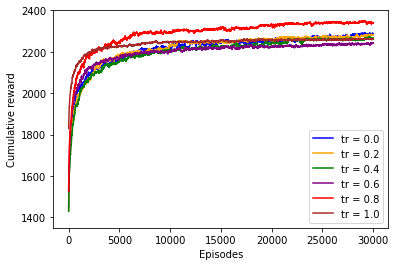

In [ ]:
restq = []

for index, tmp in enumerate(reward):

  res = []
  temp = []
  nui = 60
  for num in range(len(tmp[0])):
    avg = 0.0
    for case in tmp:
      avg += case[num]
    if len(tmp) != 0:
      temp.append(avg/(len(tmp)))
  for i, element in enumerate(temp):
    if i <= len(temp) - nui:
      s = 0
      for j in range(i, i+nui):
        s += temp[j]
      res.append(s/nui)
    else:
      s = 0
      for j in range(i-nui+1, i+1):
        s += temp[j]
      res.append(s/nui)

  restq.append(res)
x = []
for ix in range(1,30000):
  x.append(ix+1)
plt.plot(x, restq[0], label = 'tr = 0.0', color = 'blue')
plt.plot(x, restq[1], label = 'tr = 0.2', color = 'orange')
plt.plot(x, restq[2], label = 'tr = 0.4', color= 'green')
plt.plot(x, restq[4], label = 'tr = 0.6', color = 'purple')
plt.plot(x, restq[3], label = 'tr = 0.8', color = 'red')
plt.plot(x, restq[5], label = 'tr = 1.0', color ='brown')
plt.ylim(1350, 2400)
plt.ylabel("Cumulative reward")
plt.xlabel("Episodes")
plt.legend()
plt.savefig("/content/drive/MyDrive/figure/re.pdf", dpi=500, bbox_inches="tight")
plt.show() 

##experiment7


In [ ]:
def runFile(fileName, index, Ti, j):
    util = Util(fileName)
    env = simpy.Environment()
    testedT = 72000
    net = Network(env=env, listNodes=util.listNodes, baseStation=util.BaseStation)
    mc = MobileCharger(index=0, alpha=4500.0, capacity=108000, env=env, location=[250, 250])
    algorithm = GraphRlOptimizer(env=env, T=18000, testedT=testedT, trimming=0.8, delta = Ti)

    env.process(mc.operate(net, testedT, algorithm))
    env.process(algorithm.controller(mcs=[mc], net=net))
    env.process(net.runNetwork(testedT))
    env.run(until=testedT)
    results[index].append(net.countDeadNodes())
    runtime[index].append(algorithm.runtime)
    log = mc.log
    for ob in algorithm.reward_log:
      reward[index].append(ob)
    t1 = 0
    t2 = 0
    now = net.baseStation.location
    for action in log:
        t1 = t1 + distance.euclidean(now, action[0]) / mc.velocity * mc.pm
        t2 = t2 + action[3]
    moving[index].append(t1)
    charging[index].append(t2)

    print('Time: ' + str(env.now) + ' The number of dead node:' + str(net.countDeadNodes()))


def toLine(tF, arr):
    res = str(tF) + '\t'
    avg = 0
    for num in arr:
        res = res + str(num) + '\t'
        avg += num
    if len(arr) != 0:
        avg /= len(arr)
    res = res + str(avg) + '\n'
    return res

def writeTxt():
    resultFile = open(resultFolder + '/' + 'result.txt', 'w')
    movingFile = open(resultFolder + '/' + 'movingEnergy.txt', 'w')
    chargingFile = open(resultFolder + '/' + 'chargingEnergy.txt', 'w')
    rewardFile = open(resultFolder + '/' + 'reward.txt', 'w')
    timeFile = open(resultFolder + '/' + 'time.txt', 'w')
    for i, line in enumerate(results):
        resultFile.write(toLine(listT[i], results[i]))
        movingFile.write(toLine(listT[i], moving[i]))
        chargingFile.write(toLine(listT[i], charging[i]))
        timeFile.write(toLine(listT[i], runtime[i]))
        tmp = reward[i]
        temp = []
        if len(tmp) == 0:
          continue
        temp.append(len(tmp))
        for num in range(len(tmp[0])):
          avg = 0.0
          for case in tmp:
            avg += case[num]
          if temp[0] != 0:
            temp.append(avg/(temp[0]))
        rewardFile.write(toLine(listT[i], temp))
    timeFile.close()
    resultFile.close()
    movingFile.close()
    chargingFile.close()
    rewardFile.close()


dataFolder = "/content/drive/MyDrive/data"
resultFolder = "/content/drive/MyDrive/result/experiment7"
listT = [1, 10, 50, 100 ,200, 500]
listFile = os.listdir(dataFolder)
results = []
moving = []
charging = []
reward = []
runtime = []
seed_num = 5
for i in range(len(listT)):
    runtime.append([])
    results.append([])
    charging.append([])
    moving.append([])
    reward.append([])
for i, T in enumerate(listT):
  threads = []
  for j, file in enumerate(listFile):
    runFile(dataFolder + '/' + file, i, T, j)
writeTxt()
print(results)


  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.5.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Time: 0 The number of dead node:0
0.21389001775287148  0.2566680213034458
[1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 7680.198835190542, 3537.2857757417555, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 1599.101594268503, 2852.946014312805, 5807.748269597304, 1599.101594268503, 5807.748269597304, 2502.132445132826, 2963.05062701688, 5807.748269597304, 1599.101594268503, 1599.10

In [ ]:
while True:
  pass

KeyboardInterrupt: ignored

##plot1

In [ ]:
label = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
deadnode = [35.4/4, 35.6/4, 35.2/4, 34.6/4, 32.6/4, 35.2/4]
runtime = [207.1, 163.8, 125.8, 81.9, 54.4, 36.4]
moving = [828.55/4000, 655.19/4000, 503.93/4000, 327.60/4000, 217.49/4000, 145.89/4000]
charging = [294078.31/4000 + 10, 296519.26/4000 + 10, 299899.48/4000 + 10, 306917.05/4000 + 10, 312828.49/4000 + 10, 261087.0725210611/4000 + 16.5]
energymc = [moving[i] + charging[i] for i in range(len(moving))]
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt
import numpy as np

def plotting_several_axis(variables, positions, colors, ylabels, xlabel, yaxislabels, 
                          fontsize=12, y_axis_dist = 0.2, figsize=(7,5)):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)


    fig, host = plt.subplots(figsize=figsize)
    fig.subplots_adjust(right=0.75)


    ###### HOST PLOTTING
    tkw = dict(size=4, width=1.5, labelsize=fontsize)


    p1, = host.plot(variables[0][0], variables[0][1], colors[0], label=ylabels[0], marker ='D')
    host.set_xlabel(xlabel, fontsize=fontsize)
    host.set_ylabel(yaxislabels[0], fontsize=fontsize)
    host.yaxis.label.set_color(p1.get_color())
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)
    # host.set_xlim(0, 2)

    lines = [p1]

#     y_axis_dist = 0.2
    inc_r = 1
    inc_l = -y_axis_dist

    for ix, i in enumerate(variables):


        if ix != 0:
            par = host.twinx()
            if positions[ix] == 'right':
                par.spines[positions[ix]].set_position(("axes", inc_r))
                inc_r += y_axis_dist
            elif positions[ix] == 'left':
                par.spines[positions[ix]].set_position(("axes", inc_l))
                inc_l -= y_axis_dist

            make_patch_spines_invisible(par)
            par.spines[positions[ix]].set_visible(True)
            par.yaxis.set_label_position(positions[ix])
            par.yaxis.set_ticks_position(positions[ix])
            p, = par.plot(variables[ix][0], variables[ix][1], colors[ix], label=ylabels[ix], marker='D')
            par.set_ylabel(yaxislabels[ix], fontsize=fontsize)
            par.yaxis.label.set_color(p.get_color())
            par.tick_params(axis='y', colors=p.get_color(), **tkw)
            lines.append(p)
    plt.xticks(label, label)
    host.grid('x', color='0.85',linestyle="--")
    host.grid('y', color='0.85',linestyle="--")
    host.legend(lines, [l.get_label() for l in lines], fontsize=fontsize, loc='lower left')
    plt.savefig("/content/drive/MyDrive/figure/merger3.pdf", dpi=300, bbox_inches="tight")

    plt.show()

variables = [[label, deadnode], [label, charging], [label, runtime]]
positions = ['left', 'right', 'right']
colors = ['red', 'blue', 'green']
ylabels = ['Node failure ratio', 'Charging energy', 'Running time']
xlabel = 'Trimming factor'
yaxislabels = ['%', 'kJ', 'second']

plotting_several_axis(variables, positions, colors, ylabels, xlabel, yaxislabels, y_axis_dist=0.2)

[8.85, 8.9, 8.8, 8.65, 8.15, 8.8]
[207.1, 163.8, 125.8, 81.9, 54.4, 36.4]
[83.5195775, 84.12981500000001, 84.97487, 86.72926249999999, 88.2071225, 81.77176813026527]


FileNotFoundError: ignored

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


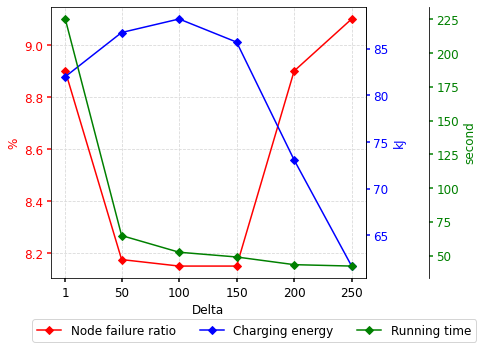

[1, 50, 100, 150, 200, 250]
[8.9, 8.175, 8.15, 8.15, 8.9, 9.1]
[82.0125, 86.75475, 88.2071225, 85.722, 73.073, 61.6755]
[225.1425, 64.835, 52.4975, 48.975, 43.3, 42.25]


In [ ]:
label = [1, 50, 100, 150, 200, 250]
deadnode = [35.6/4, 32.7/4, 32.6/4, 32.6/4, 35.6/4, 36.4/4]
runtime = [900.57/4, 259.34/4, 209.99/4, 195.9/4, 173.2/4, 169/4]
moving = [2849/4, 3045/4, 3140/4, 3071/4, 2897/4, 2614/4]
charging = [328050/4000, 347019/4000, 312828.49/4000 + 10, 342888/4000, 292292/4000, 246702/4000]
energymc = [moving[i] + charging[i] for i in range(len(moving))]
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages(r'/content/drive/MyDrive/figure/node.pdf') as export_pdf1:
  plt.xticks(label, label)
  plt.grid('x', color='0.85',linestyle="--")
  plt.grid('y', color='0.85',linestyle="--")
  plt.plot(label, deadnode, marker = 'D', color = 'red');
  plt.ylabel("Node failure ratio (%)")
  plt.xlabel("Trimming factor")
  export_pdf1.savefig()
  plt.close()

with PdfPages(r'/content/drive/MyDrive/figure/run-time.pdf') as export_pdf2:
  plt.xticks(label, label)
  plt.grid('x', color='0.85',linestyle="--")
  plt.grid('y', color='0.85',linestyle="--")
  plt.plot(label, runtime, marker = 'D', color = 'red')
  plt.ylabel("Run-time (s)")
  plt.xlabel("Trimming factor")
  export_pdf2.savefig()
  plt.close()

with PdfPages(r'/content/drive/MyDrive/figure/charge.pdf') as export_pdf3:
  plt.xticks(label, label)
  plt.grid('x', color='0.85',linestyle="--")
  plt.grid('y', color='0.85',linestyle="--")
  plt.plot(label, charging, marker = 'D', color = 'red')
  plt.ylabel("Charge energy (kJ)")
  plt.xlabel("Trimming factor")
  export_pdf3.savefig()
  plt.close()

with PdfPages(r'/content/drive/MyDrive/figure/move.pdf') as export_pdf4:
  plt.xticks(label, label)
  plt.grid('x', color='0.85',linestyle="--")
  plt.grid('y', color='0.85',linestyle="--")
  plt.plot(label, moving, marker = 'D', color = 'red')
  plt.ylabel("Move energy (kJ)")
  plt.xlabel("Trimming factor")
  export_pdf4.savefig()
  plt.close()

import matplotlib.pyplot as plt
import numpy as np

def plotting_several_axis(variables, positions, colors, ylabels, xlabel, yaxislabels, 
                          fontsize=12, y_axis_dist = 0.2, figsize=(7,5)):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)


    fig, host = plt.subplots(figsize=figsize)
    fig.subplots_adjust(right=0.75)


    ###### HOST PLOTTING
    tkw = dict(size=4, width=1.5, labelsize=fontsize)


    p1, = host.plot(variables[0][0], variables[0][1], colors[0], label=ylabels[0], marker ='D')
    host.set_xlabel(xlabel, fontsize=fontsize)
    host.set_ylabel(yaxislabels[0], fontsize=fontsize)
    host.yaxis.label.set_color(p1.get_color())
    host.tick_params(axis='y', colors=p1.get_color(), **tkw)
    host.tick_params(axis='x', **tkw)
    # host.set_xlim(0, 2)

    lines = [p1]

#     y_axis_dist = 0.2
    inc_r = 1
    inc_l = -y_axis_dist

    for ix, i in enumerate(variables):


        if ix != 0:
            par = host.twinx()
            if positions[ix] == 'right':
                par.spines[positions[ix]].set_position(("axes", inc_r))
                inc_r += y_axis_dist
            elif positions[ix] == 'left':
                par.spines[positions[ix]].set_position(("axes", inc_l))
                inc_l -= y_axis_dist

            make_patch_spines_invisible(par)
            par.spines[positions[ix]].set_visible(True)
            par.yaxis.set_label_position(positions[ix])
            par.yaxis.set_ticks_position(positions[ix])
            p, = par.plot(variables[ix][0], variables[ix][1], colors[ix], label=ylabels[ix], marker='D')
            par.set_ylabel(yaxislabels[ix], fontsize=fontsize)
            par.yaxis.label.set_color(p.get_color())
            par.tick_params(axis='y', colors=p.get_color(), **tkw)
            lines.append(p)
    host.legend(lines, [l.get_label() for l in lines], fontsize=fontsize,bbox_to_anchor=(1.35, -0.15), ncol = 3, borderaxespad=0)
    plt.xticks(label, label)
    host.grid('x', color='0.85',linestyle="--")
    host.grid('y', color='0.85',linestyle="--")
    plt.savefig("/content/drive/MyDrive/figure/merger3.pdf", dpi=300, bbox_inches="tight")
    plt.show()

variables = [[label, deadnode], [label, charging], [label, runtime]]
positions = ['left', 'right', 'right']
colors = ['red', 'blue', 'green']
ylabels = ['Node failure ratio', 'Charging energy', 'Running time']
xlabel = 'Delta'
yaxislabels = ['%', 'kJ', 'second']

plotting_several_axis(variables, positions, colors, ylabels, xlabel, yaxislabels, y_axis_dist=0.2)